In [12]:
import findspark
findspark.init() 
import pyspark
from pyspark.sql.session import SparkSession

In [13]:
spark = SparkSession.builder \
   .master("local") \
   .appName("StockMarket") \
   .config("spark.executor.memory", "6gb") \
   .getOrCreate()

In [14]:
aapl = spark.read.format('com.databricks.spark.csv')\
                    .options(header='true', inferschema='true')\
                    .load('AAPL.csv')

Visualization

In [15]:
df = aapl

In [16]:
import pyspark.sql.functions as f
df = df.withColumn('date', f.to_date('Date'))

In [17]:
df = df.sort("date")

In [18]:
date_breakdown = ['year', 'month', 'day']
for i in enumerate(date_breakdown):
    index = i[0]
    name = i[1]
    df = df.withColumn(name, f.split("date", '-')[index])

df.show(5)

+----------+-----+-----+-----+-----+-------+---------+----+-----+---+
|      date| Open| High|  Low|Close| Volume|Adj Close|year|month|day|
+----------+-----+-----+-----+-----+-------+---------+----+-----+---+
|1984-09-07| 26.5|26.87|26.25| 26.5|2981600|     3.02|1984|   09| 07|
|1984-09-10| 26.5|26.62|25.87|26.37|2346400|     3.01|1984|   09| 10|
|1984-09-11|26.62|27.37|26.62|26.87|5444000|     3.07|1984|   09| 11|
|1984-09-12|26.87| 27.0|26.12|26.12|4773600|     2.98|1984|   09| 12|
|1984-09-13| 27.5|27.62| 27.5| 27.5|7429600|     3.14|1984|   09| 13|
+----------+-----+-----+-----+-----+-------+---------+----+-----+---+
only showing top 5 rows



In [19]:
df_plot = df.select('year', 'Adj Close').toPandas()

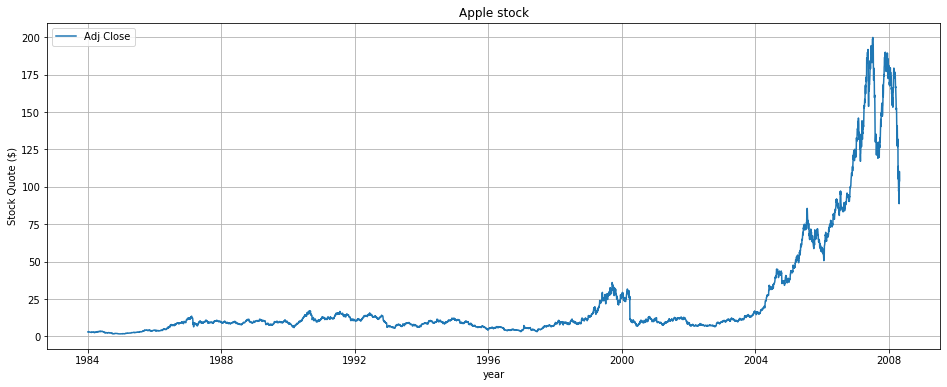

In [20]:
from matplotlib import pyplot as plt
%matplotlib inline
df_plot.set_index('year', inplace=True)
df_plot.plot(figsize=(16, 6), grid=True)
plt.title('Apple stock')
plt.ylabel('Stock Quote ($)')
plt.show()

In [22]:
volume_plot = df.select('year','Volume').toPandas()

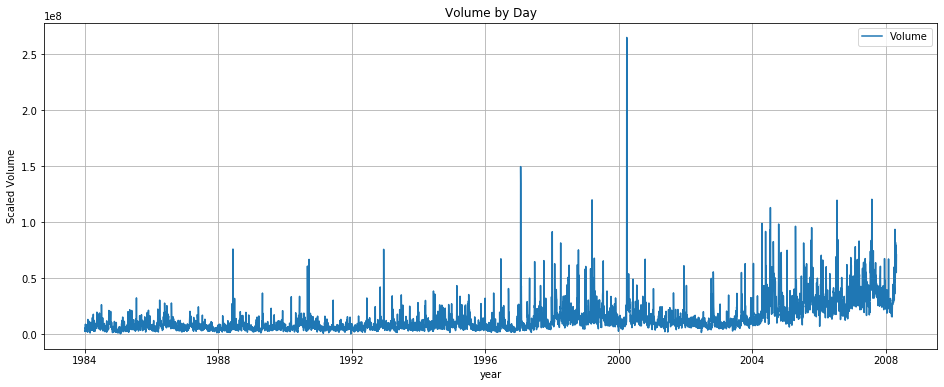

In [23]:
volume_plot.set_index('year', inplace=True)
volume_plot.plot(figsize=(16, 6), grid=True)
plt.title('Volume by Day')
plt.ylabel('Scaled Volume')
plt.show()

In [24]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['Open', 'High', 'Low', 'Close', 'Volume'], outputCol = 'features')
v_df = vectorAssembler.transform(aapl)


In [25]:
splits = v_df.randomSplit([0.8, 0.2])
trainDF = splits[0]
testDF = splits[1]

In [26]:
trainDF.toPandas().shape

(4895, 8)

In [27]:
trainDF.show(5)

+----------+-----+-----+-----+-----+-------+---------+--------------------+
|      Date| Open| High|  Low|Close| Volume|Adj Close|            features|
+----------+-----+-----+-----+-----+-------+---------+--------------------+
|1984-09-07| 26.5|26.87|26.25| 26.5|2981600|     3.02|[26.5,26.87,26.25...|
|1984-09-10| 26.5|26.62|25.87|26.37|2346400|     3.01|[26.5,26.62,25.87...|
|1984-09-12|26.87| 27.0|26.12|26.12|4773600|     2.98|[26.87,27.0,26.12...|
|1984-09-13| 27.5|27.62| 27.5| 27.5|7429600|     3.14|[27.5,27.62,27.5,...|
|1984-09-14|27.62| 28.5|27.62|27.87|8826400|     3.18|[27.62,28.5,27.62...|
+----------+-----+-----+-----+-----+-------+---------+--------------------+
only showing top 5 rows



In [28]:
testDF.toPandas().shape

(1186, 8)

Linear Regression

In [29]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='Adj Close', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(trainDF)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.21508366808334164,0.13314704637547206,0.2999044485371002,0.21921432433130164,5.77057639043591e-07]
Intercept: -24.859958946479832


In [30]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 15.947100
r2: 0.820524


In [31]:
lr_predictions = lr_model.transform(testDF)
lr_predictions.select("prediction","Adj Close","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Adj Close",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+--------------------+---------+--------------------+
|          prediction|Adj Close|            features|
+--------------------+---------+--------------------+
|  1.5250500589883842|     3.07|[26.62,27.37,26.6...|
|  0.0733979073529838|     3.09|[27.12,27.37,27.1...|
|-0.03159827319191777|     3.04|[26.87,27.0,26.62...|
|  1.8127238873112823|     2.87|[25.75,25.75,24.6...|
| -1.4036149680777363|      2.8|[25.0,25.0,24.5,2...|
+--------------------+---------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.807731


In [32]:
test_result = lr_model.evaluate(testDF)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 15.8879


Random Forest Regression

In [33]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol="features", labelCol="Adj Close")

In [34]:
rf = rf.fit(trainDF)
rf_predictions = rf.transform(testDF)

In [35]:
rf_predictions.select("prediction", "Adj Close", "features").show(5)

+-----------------+---------+--------------------+
|       prediction|Adj Close|            features|
+-----------------+---------+--------------------+
| 6.86487346336077|     3.07|[26.62,27.37,26.6...|
| 6.86487346336077|     3.09|[27.12,27.37,27.1...|
| 6.86487346336077|     3.04|[26.87,27.0,26.62...|
|7.974725535261639|     2.87|[25.75,25.75,24.6...|
| 6.86487346336077|      2.8|[25.0,25.0,24.5,2...|
+-----------------+---------+--------------------+
only showing top 5 rows



In [36]:
evaluator = RegressionEvaluator(
    labelCol="Adj Close", predictionCol="prediction", metricName="r2")
rmse = evaluator.evaluate(rf_predictions)
print("R Squared (R2) on test data = %g" % rmse)

R Squared (R2) on test data = 0.908085


Gradient-boosted Tree Regression

In [37]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'Adj Close', maxIter=10)
gbt_model = gbt.fit(trainDF)
gbt_predictions = gbt_model.transform(testDF)

In [38]:
gbt_evaluator = RegressionEvaluator(
    labelCol="Adj Close", predictionCol="prediction", metricName="r2")
gbt_r2 = gbt_evaluator.evaluate(gbt_predictions)
print("R Squared (R2) on test data = %g" % gbt_r2)

R Squared (R2) on test data = 0.914417


Decision Tree Regression

In [39]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'Adj Close')
dt_model = dt.fit(trainDF)
dt_predictions = dt_model.transform(testDF)

In [40]:
dt_r2 = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Adj Close",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(dt_predictions))

R Squared (R2) on test data = 0.910347


LSTM

In [41]:
import numpy as np
trainArray = np.array(trainDF.select('Open', 'High', 'Low', 'Close','Volume', 'Adj Close' ).collect())
testArray = np.array(testDF.select('Open', 'High', 'Low', 'Close','Volume', 'Adj Close' ).collect())

In [42]:
print(trainArray[0])
print('-------------')
print(testArray[0])

[2.6500e+01 2.6870e+01 2.6250e+01 2.6500e+01 2.9816e+06 3.0200e+00]
-------------
[2.662e+01 2.737e+01 2.662e+01 2.687e+01 5.444e+06 3.070e+00]


In [43]:
from sklearn.preprocessing import MinMaxScaler
minMaxScale = MinMaxScaler()

minMaxScale.fit(trainArray)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [44]:
testingArray = minMaxScale.transform(testArray)
trainingArray = minMaxScale.transform(trainArray)

In [45]:
print(testingArray[0])
print('--------------')
print(trainingArray[0])

[0.07362555 0.07472203 0.07510266 0.07488845 0.035801   0.00719716]
--------------
[0.07298253 0.07208726 0.07310352 0.07289931 0.01933917 0.00694374]


In [46]:
xtrain = trainingArray[:, 0:-1]
xtest = testingArray[:, 0:-1]

ytrain = trainingArray[:, -1:]
ytest = testingArray[:, -1:]

In [47]:
pip install keras==2.3.0

Note: you may need to restart the kernel to use updated packages.


In [48]:
from keras import models, layers

Using TensorFlow backend.
C:\Users\Admin\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Admin\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Admin\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Admin\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [49]:
model = models.Sequential()
model.add(layers.LSTM(1, input_shape=(1,5)))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [50]:
xtrain = xtrain.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
xtest  = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))

In [51]:
loss = model.fit(xtrain, ytrain, batch_size=10, epochs=100)


Epoch 1/100
4895/4895 [==============================] - 2s 413us/step - loss: 0.0154
Epoch 2/100
4895/4895 [==============================] - 1s 282us/step - loss: 0.0073
Epoch 3/100
4895/4895 [==============================] - 1s 283us/step - loss: 0.0059
Epoch 4/100
4895/4895 [==============================] - 1s 283us/step - loss: 0.0053
Epoch 5/100
4895/4895 [==============================] - 1s 285us/step - loss: 0.0050
Epoch 6/100
4895/4895 [==============================] - 2s 384us/step - loss: 0.0048
Epoch 7/100
4895/4895 [==============================] - 2s 372us/step - loss: 0.0047
Epoch 8/100
4895/4895 [==============================] - 2s 413us/step - loss: 0.0046
Epoch 9/100
4895/4895 [==============================] - 2s 342us/step - loss: 0.0046
Epoch 10/100
4895/4895 [==============================] - 2s 394us/step - loss: 0.0046
Epoch 11/100
4895/4895 [==============================] - 3s 570us/step - loss: 0.0045 1s
Epoch 12/100
4895/4895 [========================

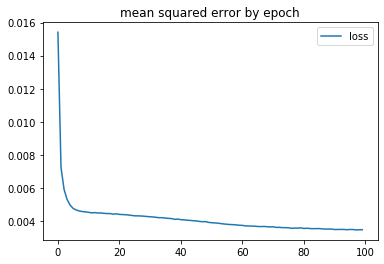

In [52]:
%matplotlib inline
plt.plot(loss.history['loss'], label = 'loss')
plt.title('mean squared error by epoch')
plt.legend()
plt.show()

In [53]:
predicted = model.predict(xtest)

In [54]:
combined_array = np.concatenate((ytest, predicted), axis = 1)

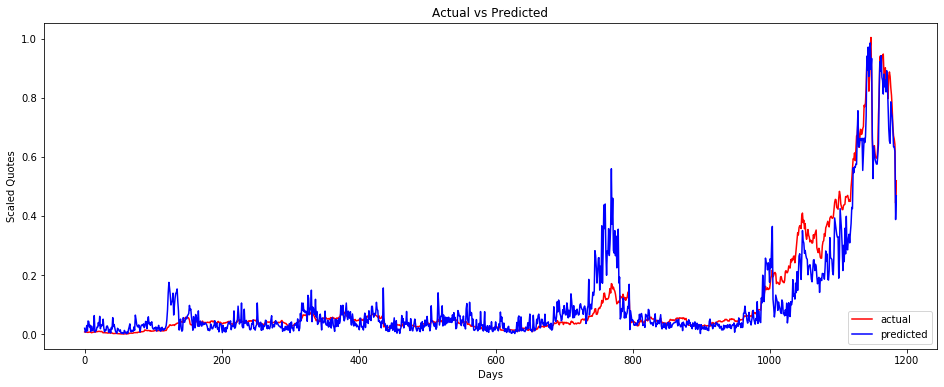

In [55]:
plt.figure(figsize=(16,6))
plt.plot(combined_array[:,0],color='red', label='actual')
plt.plot(combined_array[:,1],color='blue', label='predicted')
plt.legend(loc = 'lower right')
plt.title('Actual vs Predicted')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()

In [56]:
import sklearn.metrics as metrics
rmse = np.sqrt(metrics.mean_squared_error(ytest,predicted))

print("RMSE: %f" % rmse)

RMSE: 0.059716


In [57]:
r2 = metrics.r2_score(ytest,predicted)

print("r2 %f" % r2)

r2 0.894266
